In [41]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('seaborn-whitegrid')

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import SGD
import math
import os
import re
import calendar
from datetime import datetime
import ast

In [2]:
# Parsing general parameters

path_to_CTA = '/home/jupyter/CTA data/'
path_to_params = '/home/jupyter/CTA params/'
cutoff_date = '2006-12-01'
fileNames = os.listdir(path_to_CTA)
fileNames = list(filter(lambda x: x.endswith('.csv'), fileNames))

In [3]:
# Take crude oil data
oil = pd.read_csv(path_to_params + 'MCOILWTICO.csv')
oil.rename(columns=lambda x: x.strip(), inplace=True)
oil['DATE'] = pd.to_datetime(oil['DATE'], format='%Y-%m')
oil = oil.set_index('DATE')

In [4]:
# Take gold data
aux = pd.read_csv(path_to_params + 'AUX-USD-2592000-20200523172420.csv', parse_dates=['Date'])
aux.rename(columns=lambda x: x.strip(), inplace=True)
aux['Date'] = aux['Date'].apply(lambda dt: dt.replace(day=1))
aux.drop_duplicates(subset ="Date", 
                     keep = 'first', inplace = True)
aux = aux.set_index('Date')
aux = aux.reindex(index=aux.index[::-1])

In [5]:
# Take silver data
agx = pd.read_csv(path_to_params + 'AGX-USD-2592000-20200523172540.csv', parse_dates=['Date'])
agx.rename(columns=lambda x: x.strip(), inplace=True)
agx['Date'] = agx['Date'].apply(lambda dt: dt.replace(day=1))
agx.drop_duplicates(subset ="Date", 
                     keep = 'first', inplace = True)
agx = agx.set_index('Date')
agx = agx.reindex(index=agx.index[::-1])


In [6]:
# Take Producer Price index data
ppi = pd.read_csv(path_to_params + 'PPIACO.csv', parse_dates=['DATE'])
ppi.rename(columns=lambda x: x.strip(), inplace=True)
ppi.drop_duplicates(subset ="DATE", 
                     keep = 'first', inplace = True)
ppi = ppi.set_index('DATE')

In [7]:

# Take BTOP50 index data
btop = pd.read_csv(path_to_params + 'BTOP50_Index_historical_data.csv')
btop = btop.iloc[:34]
btop_df = pd.DataFrame(columns=['Date', 'BTOP50'])
# print(btop_df)
for index, row in btop.iterrows():
    for idx, value in row[1:].items():
        year = int(row[0])
        month = list(calendar.month_abbr).index(idx)
        actual_date = datetime(year=year, month=month, day=1)
        btop_df = btop_df.append({'Date':actual_date,'BTOP50':value},ignore_index=True)
        btop_df = btop_df[btop_df['Date'] < '2020-05-01']
        btop_df = btop_df[btop_df['Date'] >= cutoff_date]

btop_df['BTOP50'] = btop_df['BTOP50'].apply(lambda x: x.strip('%')).astype(float)
btop_df = btop_df.set_index('Date')
del btop

In [8]:
# Take CTA index data
ctai_list = (open(path_to_params + "cta_index_formated.txt", "r").read())
ctai_list = ast.literal_eval(ctai_list)
ctai_df = pd.DataFrame.from_records(ctai_list)
ctai_df['Date'] = pd.to_datetime(ctai_df['year'].astype(str) + '-' + ctai_df['month'].astype(str), format='%Y-%m')
ctai_df = ctai_df.set_index('Date')
del ctai_list

In [9]:
CTAs = {}
end_date = '2020-03-01'
# Take CTA data
for fName in fileNames:
    df = pd.read_csv(path_to_CTA + fName)
    df.rename(columns=lambda x: x.strip(), inplace=True)
    df["Month"] = df.Month.map("{:02}".format)
    df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str), format='%Y-%m')
    df = df.set_index('Date')
    df = df.loc[cutoff_date:]
    df.drop(columns=['Year','Month'], inplace=True)
    # Insert params to df
    df['Oil'] = oil.loc[cutoff_date:]['MCOILWTICO']
    df['AUX'] = aux.loc[cutoff_date:]['Close (kg)']
    df['AGX'] = agx.loc[cutoff_date:]['Close (kg)']
    df['PPI'] = ppi.loc[cutoff_date:]['PPIACO']
    df['BTOP50'] = btop_df['BTOP50']
    df['CTA_IDX'] = ctai_df.loc[cutoff_date:]['value']
    df.ffill(axis=0, inplace=True, limit=None, downcast=None)
    CTAs[fName] = df.loc[:end_date]

del oil, aux, agx, ppi, ctai_df, btop_df    

In [10]:
train_start = '2006-12-01'
train_end = '2016-01-01' # inclusive
test_end = '2020-04-01' # inclusive

for fName in fileNames:
    # Mark as train and test sets
    df = CTAs[fName]
    df['DataSet_1'] = 'Test'
    df.loc[train_start:train_end,'DataSet_1'] = 'Train'
    
print(len(CTAs[fileNames[0]].loc[train_start:train_end]))
print(len(CTAs[fileNames[0]].loc[train_end:]))

110
51


In [11]:
# Scaling the training and testing set
transform_train = {}
transform_test = {}
scaler = {}

for num, fName in enumerate(fileNames): 
    sc = MinMaxScaler(feature_range=(0,1))
    df = CTAs[fName]
    a0 = np.array(df[df["DataSet_1"] == 'Train'].iloc[:,:-1])
    a1 = np.array(df[df["DataSet_1"] == 'Test'].iloc[:,:-1])
    transform_train[fName] = sc.fit_transform(a0)
    transform_test[fName] = sc.fit_transform(a1)
    scaler[fName] = sc

del a0
del a1

In [12]:
trainset = {}
testset = {}

timestep = 10
train_set_size = 110 # default value
test_set_size = 50 # defaul value
feature_count = 8

# For every CTA, create train set and validation set
# the value of past 10 time steps
# Result of input should be 3D Vector (Sample size, time steps, features)
# in this case for train set (100, 10, 8)
# for test set (40, 10, 8)
# total sample size 161 = 100 (train set) + 10 (validation set) + 40 (test set) + 10
 
for fName in fileNames:
    train_set_size = len(transform_train[fName]) 
    test_set_size = len(transform_test[fName])
    # Create train set
    trainset[fName] = {}
    X_train = []
    y_train = []
    for i in range(timestep,train_set_size):
        X_train.append(transform_train[fName][i-timestep:i,:])
        y_train.append(transform_train[fName][i,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    trainset[fName]["X"] = np.reshape(X_train, (X_train.shape[0],X_train.shape[1], feature_count))
    trainset[fName]["y"] = y_train

    # Create test set
    testset[fName] = {}
    X_test = []
    y_test = []    
    for i in range(timestep, test_set_size):
        X_test.append(transform_test[fName][i-timestep:i,:])
        y_test.append(transform_test[fName][i,0])
    
    X_test, y_test = np.array(X_test), np.array(y_test)
    testset[fName]["X"] = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], feature_count))
    testset[fName]["y"] = y_test

In [13]:
# Check the shapes of input
arr_buff = []
for i in fileNames:
    buff = {}
    buff["X_train"] = trainset[i]["X"].shape
    buff["y_train"] = trainset[i]["y"].shape
    buff["X_test"] = testset[i]["X"].shape
    buff["y_test"] = testset[i]["y"].shape
    arr_buff.append(buff)

pd.DataFrame(arr_buff, index=fileNames)

,X_train,y_train,X_test,y_test
Mondiale-Asset-Management-Mondiale-Trading-Program-2X-_data.csv,"(100, 10, 8)","(100,)","(40, 10, 8)","(40,)"
FTC-Capital-GmbH-FTC-Futures-Fund-Classic-EUR-_data.csv,"(100, 10, 8)","(100,)","(40, 10, 8)","(40,)"
Global-Bayesian-Dynamics-LLC-SBF-Proprietary-_data.csv,"(100, 10, 8)","(100,)","(40, 10, 8)","(40,)"
Molinero-Capital-Management-LLP-Global-Markets-Program_data.csv,"(100, 10, 8)","(100,)","(40, 10, 8)","(40,)"
FORT-LP-Fort-Global-Contrarian_data.csv,"(100, 10, 8)","(100,)","(40, 10, 8)","(40,)"
...,...,...,...,...
DUNN-Capital-Management-World-Monetary-and-Agriculture-Program-WMA-_data.csv,"(100, 10, 8)","(100,)","(40, 10, 8)","(40,)"
Adalpha-Asset-Management-LLC-Adalpha-Diversified-Short-Term-Program_data.csv,"(100, 10, 8)","(100,)","(40, 10, 8)","(40,)"
Mulvaney-Capital-Management-The-Mulvaney-Global-Markets-Fund_data.csv,"(100, 10, 8)","(100,)","(40, 10, 8)","(40,)"
AIS-Capital-Management-L-P-MAAP-3x-6x-Composite_data.csv,"(100, 10, 8)","(100,)","(40, 10, 8)","(40,)"


In [ ]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=30, return_sequences=False, input_shape=(X_train.shape[1],feature_count)))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
# Fitting to the training set
for i, fName in enumerate(fileNames):
    print(i+1, ". Fitting to", fName)
    regressor.fit(trainset[fName]["X"], trainset[fName]["y"], epochs=30, batch_size=200)

In [15]:
from keras.models import load_model
# regressor.save('cta_60.h5')
regressor = load_model('cta_60.h5', custom_objects=None, compile=True)

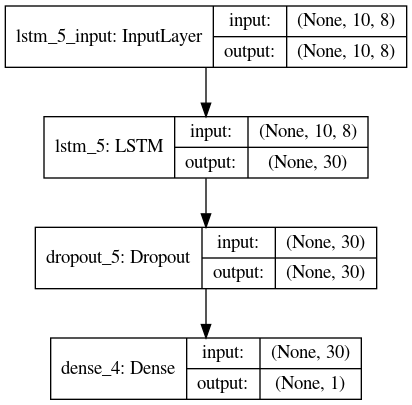

In [17]:
from keras.utils import plot_model
img_file = 'model_2.png'
plot_model(regressor, to_file=img_file, show_shapes=True)

In [105]:
regressor.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 30)                4680      
_________________________________________________________________
dropout_5 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 31        
Total params: 4,711
Trainable params: 4,711
Non-trainable params: 0
_________________________________________________________________


In [74]:
def fill_error_dictionary(dict, true_vals, pred_vals, round_count = 4):
    mse = mean_squared_error(true_vals, pred_vals)
    dict["MSE"] = round(mse, round_count)
    dict["RMSE"] = round(math.sqrt(mse), round_count)
    dict["MAE"] = round(mean_absolute_error(true_vals, pred_vals), round_count)

In [75]:
pred_result = {}
error_dict = {"RNN": {}, "LIN_R": {}, "LASSO": {}, "RIDGE":{}}
true_arr = np.array([])
pred_arr = np.array([])


for fName in fileNames:
    # With inverse scaling
    # y_true = scaler[fName].inverse_transform(testset[fName]["y"].reshape(-1,8))
    # y_pred = scaler[fName].inverse_transform(regressor.predict(testset[fName]["X"]))
    pred_norm = regressor.predict(testset[fName]["X"])
    true_norm = testset[fName]["y"]
    true_arr = np.append(true_arr, true_norm)
    pred_arr = np.append(pred_arr, pred_norm)
    pred_result[fName] = {}
    pred_result[fName]["True"] = true_norm
    pred_result[fName]["Pred"] = pred_norm
   
fill_error_dictionary(error_dict["RNN"], true_arr, pred_arr, 4)

In [ ]:

for fName in fileNames:
    

In [39]:
# Collect all train and test sets
all_test_x = np.array([])
all_train_x = np.array([])
all_test_y, all_train_y = np.array([]), np.array([])
for fName in fileNames:
    all_train_x = np.append(all_train_x, trainset[fName]["X"]).reshape(-1, trainset[fName]["X"].shape[1], trainset[fName]["X"].shape[2])
    all_train_y = np.append(all_train_y, trainset[fName]["y"])
    all_test_x = np.append(all_test_x, testset[fName]["X"]).reshape(-1, testset[fName]["X"].shape[1], testset[fName]["X"].shape[2])
    all_test_y = np.append(all_test_y, testset[fName]["y"])

print(all_train_x.shape, all_train_y.shape, all_test_x.shape, all_test_y.shape)
# MSEs = cross_val_score(lin_reg, Xm y, scoring='neg_mean_squared_error', cv=5)mean_MSE

(7886, 10, 8) (7886,) (3123, 10, 8) (3123,)


In [44]:
def fetch_2d_set(dataset):
        nsamples, nx, ny = dataset.shape
        return dataset.reshape((nsamples,nx*ny))

In [89]:
models = [
    ('LIN_R', LinearRegression()),
    ('LASSO', Lasso()),
    ('RIDGE', Ridge()),
]
for name, model in models:
        clf = model
        clf.fit(fetch_2d_set(all_train_x), all_train_y)
        predicted_y = model.predict(fetch_2d_set(all_test_x))
        fill_error_dictionary(error_dict[name], all_test_y, predicted_y)

error_dict

{'RNN': {'MSE': 0.0466, 'RMSE': 0.216, 'MAE': 0.1712},
 'LIN_R': {'MSE': 0.0704, 'RMSE': 0.2653, 'MAE': 0.212},
 'LASSO': {'MSE': 0.0517, 'RMSE': 0.2275, 'MAE': 0.1826},
 'RIDGE': {'MSE': 0.0636, 'RMSE': 0.2522, 'MAE': 0.2018}}

| Tiesinė regresija   | Laso regresija | Keteros regresija | Neur. tinklas | 
|------|------|-----|-----|
|   1  | 2  |3 | 4 |

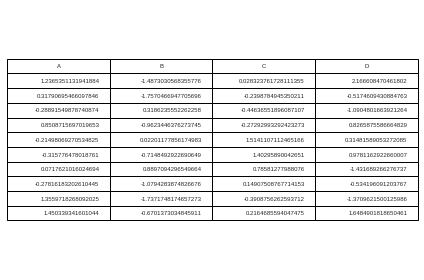

In [91]:
fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

cols = []
df = pd.DataFrame(np.random.randn(10, 4), columns=list('ABCD'))

ax.table(cellText=df.values, colLabels=df.columns, loc='center')

fig.tight_layout()

plt.show()